### Load packages


In [1]:
%matplotlib inline

import sys
import os
import warnings
import datacube
import numpy as np
import xarray as xr
import subprocess as sp
import geopandas as gpd
from datacube.utils.geometry import assign_crs
from datacube.utils.rio import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

#import deafrica specific functions
sys.path.append('../Scripts')
from deafrica_plotting import map_shapefile
from deafrica_classificationtools import collect_training_data 

#import the custom feature layer functions
from feature_layer_functions import gm_mads_two_seasons_training

warnings.filterwarnings("ignore")

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
path = 'data/Eastern_training_data_20201215.geojson' 
field = 'Class'

In [3]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(threads_per_worker=1, n_workers=25, memory_limit=400e6)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:37617 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 25 Cores: 25 Memory: 10.00 GB


In [4]:
# Load input data shapefile
gdf = gpd.read_file(path)

In [5]:
gdf.head()

,Class,geometry
0,1,"POLYGON ((32.49666 -3.30737, 32.49693 -3.30716..."
1,1,"POLYGON ((32.49314 -3.30836, 32.49382 -3.30847..."
2,1,"POLYGON ((32.49962 -3.31316, 32.50028 -3.31338..."
3,1,"POLYGON ((32.51721 -3.10441, 32.51716 -3.10465..."
4,1,"POLYGON ((32.38058 -2.69827, 32.38091 -2.69820..."


First, we need to set up a few extra inputs for `collect_training_data` and the datacube.  See the function docs [here](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/03b7b41d5f6526ff3f33618f7a0b48c0d10a155f/Scripts/deafrica_classificationtools.py#L650) for more information on these parameters.



In [6]:
#set up our inputs to collect_training_data
zonal_stats = 'median'
return_coords = True

# Set up the inputs for the ODC query
products = ['s2_l2a']
time = ('2019-01', '2019-12')
measurements = [
    'red', 'blue', 'green', 'nir', 'swir_1', 'swir_2', 'red_edge_1',
    'red_edge_2', 'red_edge_3'
]
resolution = (-20, 20)
output_crs = 'epsg:6933'

#generate a new datacube query object
query = {
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': output_crs,
    'group_by' : 'solar_day',
}

query

{'time': ('2019-01', '2019-12'),
 'measurements': ['red',
  'blue',
  'green',
  'nir',
  'swir_1',
  'swir_2',
  'red_edge_1',
  'red_edge_2',
  'red_edge_3'],
 'resolution': (-20, 20),
 'output_crs': 'epsg:6933',
 'group_by': 'solar_day'}

In [7]:
%%time
for index, row in enumerate(gdf.itertuples()):
    pass

CPU times: user 7.14 ms, sys: 0 ns, total: 7.14 ms
Wall time: 7.04 ms


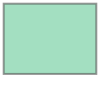

In [8]:
row.geometry

In [9]:
%%time
for index, row in gdf.iterrows():
    pass
# CPU times: user 243 ms, sys: 4.01 ms, total: 247 ms
# Wall time: 247 ms

CPU times: user 244 ms, sys: 4.88 ms, total: 249 ms
Wall time: 246 ms


In [10]:
custom_func = gm_mads_two_seasons_training

In [11]:
# results = []
# column_names = []

# # loop through polys and extract training data
# _get_training_data_for_shp(gdf, index, row, results, column_names,
#                                products, dc_query, return_coords=True,
#                                custom_func, # gm_mads_two_seasons_training
#                               field, # class label
#                                calc_indices, # None
#                                reduce_func, drop, zonal_stats)


In [12]:
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

In [13]:
from datacube.utils import geometry

In [14]:
# set up query based on polygon (convert to WGS84)
geom = geometry.Geometry(gdf.geometry.values[index],
                         geometry.CRS('epsg:4326'))

In [15]:
type(gdf.geometry.values[index]), type(row.geometry)

(shapely.geometry.polygon.Polygon, shapely.geometry.polygon.Polygon)

In [16]:
type(geom)

datacube.utils.geometry._base.Geometry

In [17]:
# print(geom)
q = {"geopolygon": geom}

# merge polygon query with user supplied query params
query.update(q)

query['dask_chunk'] = {'time': -1, 'x': 10000, 'y': 1000}

In [18]:
query

{'time': ('2019-01', '2019-12'),
 'measurements': ['red',
  'blue',
  'green',
  'nir',
  'swir_1',
  'swir_2',
  'red_edge_1',
  'red_edge_2',
  'red_edge_3'],
 'resolution': (-20, 20),
 'output_crs': 'epsg:6933',
 'group_by': 'solar_day',
 'geopolygon': Geometry(POLYGON ((31.65112326883945 -4.243618921933441, 31.6515378355519 -4.243618921933441, 31.6515378355519 -4.243304537816352, 31.65112326883945 -4.243304537816352, 31.65112326883945 -4.243618921933441)), epsg:4326),
 'dask_chunk': {'time': -1, 'x': 10000, 'y': 1000}}

In [19]:
custom_func

<function feature_layer_functions.gm_mads_two_seasons_training(ds)>

In [19]:
from deafrica_datahandling import mostcommon_crs, load_ard

In [21]:
# ds = load_ard(dc=dc, products=products, **query)

In [22]:
measurements

['red',
 'blue',
 'green',
 'nir',
 'swir_1',
 'swir_2',
 'red_edge_1',
 'red_edge_2',
 'red_edge_3']

In [23]:
product_type = 's2'
fmask_band = 'SCL'

measurements.append(fmask_band)
# 
data_bands = [band for band in measurements if band not in (fmask_band)]
mask_bands = [band for band in measurements if band not in data_bands]

In [24]:
data_bands, mask_bands

(['red',
  'blue',
  'green',
  'nir',
  'swir_1',
  'swir_2',
  'red_edge_1',
  'red_edge_2',
  'red_edge_3'],
 ['SCL'])

In [25]:
query = {'time': ('2019-01', '2019-06'),
 'measurements': ['red',
  'blue',
  'green',
  'nir',
  'swir_1',
  'swir_2',
  'red_edge_1',
  'red_edge_2',
  'red_edge_3'],
 'resolution': (-20, 20),
 'output_crs': 'epsg:6933',
 'group_by': 'solar_day'}
 #'geopolygon': Geometry(POLYGON ((31.65112326883945 -4.243618921933441, 31.6515378355519 -4.243618921933441, 31.6515378355519 -4.243304537816352, 31.65112326883945 -4.243304537816352, 31.65112326883945 -4.243618921933441)), epsg:4326),
 #'dask_chunk': {'time': -1, 'x': 10000, 'y': 1000}}

## find_datasets too slow, one thread ?

In [26]:
# dataset_list = []
# datasets = dc.find_datasets(product=products, **query)
# dataset_list.extend(datasets)

In [27]:
len(dataset_list)

243016

In [28]:
dataset_list[0]

Dataset <id=57835116-d60d-505b-8f42-69d21fb1d37c product=s2_l2a location=s3://sentinel-cogs/sentinel-s2-l2a-cogs/2019/S2B_29NLH_20190111_0_L2A/S2B_29NLH_20190111_0_L2A.json>

In [9]:
import pickle

with open('intermediate/dataset_list.pkl', 'rb') as fh:
    dataset_list = pickle.load(fh)

In [11]:
type(dataset_list), len(dataset_list)

(list, 243016)

In [30]:
pq_categories_s2=['vegetation','snow or ice',
                               'water','bare soils',
                               'unclassified', 'dark area pixels']

In [13]:
dc = datacube.Datacube(app='training_data')

## loading too slow, one thread ?

In [ ]:
%%time
dask_chunks = {'time': -1, 'x': 10000, 'y': 10000}

ds = dc.load(datasets=dataset_list,
#              dask_chunks=dask_chunks, 
             **query)

In [ ]:
ds

In [2]:
dir()

['In',
 'Out',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i2',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'exit',
 'get_ipython',
 'quit']

In [59]:
!mkdir intermediate

In [ ]:
%%time
ds.load()


In [ ]:
ds

In [ ]:
ds.to_zarr('intermediate/data_retrieved.zarr', 'w')

In [ ]:
# sentinel 2                     
if product_type == 's2':
    # product_type is s2
    # currently broken for mask band values >=8
    # pq_mask = odc.algo.fmask_to_bool(ds[fmask_band],
    #                             categories=pq_categories_s2)
    flags_s2 = dc.list_measurements().loc[products[0]].loc[fmask_band]['flags_definition']['qa']['values']
    pq_mask = ds[fmask_band].isin([int(k) for k, v in flags_s2.items() if v in pq_categories_s2])


###############
# Apply masks #
###############

# Generate good quality data mask
mask = None
if mask_pixel_quality:
    print('Applying pixel quality/cloud mask')
    mask = pq_mask

ds_data = ds[data_bands]
ds_masks = ds[mask_bands]

# Mask data if either of the above masks were generated
if mask is not None:
    ds_data = odc.algo.keep_good_only(ds_data, where=mask)

# Automatically set dtype to either native or float32 depending
# on whether masking was requested
if dtype == 'auto':
    dtype = 'native' if mask is None else 'float32'

# Set nodata values using odc.algo tools to reduce peak memory
# use when converting data dtype    
if dtype != 'native':
    ds_data = odc.algo.to_float(ds_data, dtype=dtype)


attrs = ds.attrs
ds = xr.merge([ds_data, ds_masks])
ds.attrs.update(attrs)

###############
# Return data #
###############

# Drop bands not originally requested by user
requested_measurements = measurements
if requested_measurements:
    ds = ds[requested_measurements]


# If user supplied dask_chunks, return data as a dask array without
# actually loading it in
if dask_chunks is not None:
    # skipped
    print(f'Returning {len(ds.time)} time steps as a dask array')
    return ds
else:
    print(f'Loading {len(ds.time)} time steps')
    # TODO: only use lazay, remove compute() below
    return ds.compute()

In [ ]:
# remaining of _get_training_data_for_shp
# create polygon mask
with HiddenPrints():
    mask = xr_rasterize(gdf.iloc[[index]], ds)

# Use custom function for training data if it exists
if custom_func is not None:
    with HiddenPrints():
        data = custom_func(ds)
        data = data.where(mask)

else:
    # mask dataset
    ds = ds.where(mask)
    # first check enough variables are set to run functions
    if (len(ds.time.values) > 1) and (reduce_func == None):
        raise Exception(
            "You're dataset has " + str(len(ds.time.values)) +
            " time-steps, please provide a time reduction function," +
            " e.g. reduce_func='mean'")

    if calc_indices is not None:
        # determine which collection is being loaded
        if 'level2' in products[0]:
            collection = 'c2'
        elif 'gm' in products[0]:
            collection = 'c2'
        elif 'sr' in products[0]:
            collection = 'c1'
        elif 's2' in products[0]:
            collection = 's2'

        if len(ds.time.values) > 1:

            if reduce_func in ['mean', 'median', 'std', 'max', 'min']:
                with HiddenPrints():
                    data = calculate_indices(ds,
                                             index=calc_indices,
                                             drop=drop,
                                             collection=collection)
                    # getattr is equivalent to calling data.reduce_func
                    method_to_call = getattr(data, reduce_func)
                    data = method_to_call(dim='time')

            elif reduce_func == 'geomedian':
                data = GeoMedian().compute(ds)
                with HiddenPrints():
                    data = calculate_indices(data,
                                             index=calc_indices,
                                             drop=drop,
                                             collection=collection)

            else:
                raise Exception(
                    reduce_func + " is not one of the supported" +
                    " reduce functions ('mean','median','std','max','min', 'geomedian')"
                )

        else:
            with HiddenPrints():
                data = calculate_indices(ds,
                                         index=calc_indices,
                                         drop=drop,
                                         collection=collection)

    # when band indices are not required, reduce the
    # dataset to a 2d array through means or (geo)medians
    if calc_indices is None:

        if len(ds.time.values) > 1:

            if reduce_func == 'geomedian':
                data = GeoMedian().compute(ds)

            elif reduce_func in ['mean', 'median', 'std', 'max', 'min']:
                method_to_call = getattr(ds, reduce_func)
                data = method_to_call('time')
        else:
            data = ds.squeeze()

if return_coords == True:
    # turn coords into a variable in the ds
    data['x_coord'] = ds.x + 0 * ds.y
    data['y_coord'] = ds.y + 0 * ds.x

if zonal_stats is None:
    # If no zonal stats were requested then extract all pixel values
    flat_train = sklearn_flatten(data)
    flat_val = np.repeat(row[field], flat_train.shape[0])
    stacked = np.hstack((np.expand_dims(flat_val, axis=1), flat_train))

elif zonal_stats in ['mean', 'median', 'std', 'max', 'min']:
    method_to_call = getattr(data, zonal_stats)
    flat_train = method_to_call()
    flat_train = flat_train.to_array()
    stacked = np.hstack((row[field], flat_train))

else:
    raise Exception(zonal_stats + " is not one of the supported" +
                    " reduce functions ('mean','median','std','max','min')")

#return unique-id so we can index if dc.load fails silently
_id = gdf.iloc[index]['id']

# Append training data and labels to list
out_arrs.append(np.append(stacked, _id))
out_vars.append([field] + list(data.data_vars) + ['id'])

In [10]:
print(column_names)
print('')
print(np.array_str(model_input, precision=2, suppress_small=True))

['Class', 'red_S1', 'blue_S1', 'green_S1', 'nir_S1', 'swir_1_S1', 'swir_2_S1', 'red_edge_1_S1', 'red_edge_2_S1', 'red_edge_3_S1', 'edev_S1', 'sdev_S1', 'bcdev_S1', 'NDVI_S1', 'LAI_S1', 'MNDWI_S1', 'rain_S1', 'red_S2', 'blue_S2', 'green_S2', 'nir_S2', 'swir_1_S2', 'swir_2_S2', 'red_edge_1_S2', 'red_edge_2_S2', 'red_edge_3_S2', 'edev_S2', 'sdev_S2', 'bcdev_S2', 'NDVI_S2', 'LAI_S2', 'MNDWI_S2', 'rain_S2', 'slope', 'x_coord', 'y_coord']

[[       1.          0.13        0.08 ...        3.    3137450.
   -395860.  ]
 [       1.          0.09        0.06 ...        3.    3135790.
   -422500.  ]
 [       1.          0.09        0.06 ...        2.95  3135520.
   -421710.  ]
 ...
 [       1.          0.05        0.05 ...        5.56  3660080.
  -1321340.  ]
 [       1.          0.09        0.05 ...        6.01  3945510.
    926100.  ]
 [       1.          0.12        0.07 ...       11.84  3316340.
     88750.  ]]


## Seperate the coordinates

By setting `return_coords=True` in the `collect_training_data` function, our training data now has two extra columns called `x_coord` and `y_coord`.  We need to seperate these from our training dataset as they will not be used to train the machine learning model. Instead, these variables will be used to help conduct Spatial K-fold Cross validation (SKVC) in the notebook `3_Train_fit_evaluate_classifier`.  For more information on why this is important, see this [article](https://www.tandfonline.com/doi/abs/10.1080/13658816.2017.1346255?journalCode=tgis20).

In [11]:
coordinates_filename = "results/training_data/training_data_coordinates_20201217.txt"

In [12]:
coord_variables = ['x_coord', 'y_coord']
model_col_indices = [column_names.index(var_name) for var_name in coord_variables]

np.savetxt(coordinates_filename, model_input[:, model_col_indices])

## Export training data

Once we've collected all the training data we require, we can write the data to disk. This will allow us to import the data in the next step(s) of the workflow.


In [13]:
#set the name and location of the output file
output_file = "results/training_data/gm_mads_two_seasons_training_data_20201217.txt"

In [14]:
#grab all columns except the x-y coords
model_col_indices = [column_names.index(var_name) for var_name in column_names[0:-2]]
#Export files to disk
np.savetxt(output_file, model_input[:, model_col_indices], header=" ".join(column_names[0:-2]), fmt="%4f")

## Next steps

To continue working through the notebooks in this `Eastern Africa Cropland Mask` workflow, go to the next notebook `2_Inspect_training_data.ipynb`.

1. **Extracting_training_data (this notebook)** 
2. [Inspect_training_data](2_Inspect_training_data.ipynb)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Dec 2020
